# Atividade 04 - Aprendizado Supervisionado 2

Aluno: Pedro Henrique Cardoso Paulo<br>
Disciplina: HIML<br>
Professor: Helon

Nessa atividade seguiremos usando as bases de dados consideradas nas atividades 2 e 3. Nessa etapa, vamos estudar opções de busca randômica de hiperparâmetros e reamostragem.

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import numpy as np
import pandas as pd
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from scipy import stats
import warnings
import json

# Normalizadores
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Reducao de dimensionalidade
from sklearn.decomposition import PCA

# Resampling
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV

#Pipeline
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metricas de erro
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## Passo 1 - Importando os dados

In [2]:
fname = join(getcwd(),'data','data_postAR.pkl')
with open(fname, 'rb') as file:
    X1, y = pickle.load(file)

In [3]:
print(X1.shape, y.shape)

(850, 124) (850,)


## Passo 2 - Aplicando a reamostragem

A reamostragem será feita de modo a garantir um total de 40% das amostras para teste

In [4]:
#Pequenas melhorias desde a última rodada
# 1 - Mudando a seed aleatória pra 71 (número que passou pela minha cabeça)
# 2 - Usando o parâmetro stratify pra melhorar a segregação das classes
# 3 - Estamos usando 40% só pra treino, pra deixar mais interessante o erro
size = 0.4
X1_tr, X1_te, y_tr, y_te = train_test_split(X1, y, test_size=size, random_state=71, stratify=y)

## Passo 3 - Definindo o Pipeline a ser usado

Antes de iniciarmos os ajustes de modelo, vamos definir o Pipeline que pretendemos estudar. Até agora, todos os nossos estudos focaram nas seguintes etapas:

* Adimensionalizar os dados (MinMaxScaler)
* Aplicar um método de Feature Extraction (PCA)
* Ajuste de um método

Esses três passos devem ser contemplados no Pipeline a ser usado e os hiperparâmetros serão os adequados para cada método. Adicionalmente, tentarei usar o n_components do PCA como um hiperparâmetro. Também farei o teste para os dois Scalers (StandardScaler e MinMaxScaler). Abaixo, a imagem tenta smarizar o nosso pipeline.

<img src="images\Workflow.png">

De modo a facilitar a definição do Pipeline, faremos um método de conveniência para declará-lo.

In [5]:
def declara_Pipeline_MinMax(tupla_metodo):
    
    steps = [
        ('Scaler', MinMaxScaler()),
        ('PCA',    PCA(n_components=0.99)),
        tupla_metodo,
    ]
    return Pipeline(steps)


def declara_Pipeline_Standard(tupla_metodo):
    
    steps = [
        ('Scaler', StandardScaler()),
        ('PCA',    PCA(n_components=0.99)),
        tupla_metodo,
    ]
    return Pipeline(steps)

## Passo 4 - Listando os modelos a serem testados e definindo hiperparâmetros a tunar

Nessa etapa, vamos criar a lista dos modelos que queremos testar.

### 4.1 - Lista de modelos testados

In [6]:
models = [
    ('SoftMax', LogisticRegression(multi_class='multinomial', max_iter=5000, solver='saga', random_state=71)),
    ('SVM',     SVC(max_iter=-1, random_state=71)),
    ('KNN',     KNeighborsClassifier()),
]


### 4.2 - Lista de parâmetros

A lista é em grande parte inspirada nos testes que fizemos na Atividade 03. Algumas variáveis que não tinha sensibilidade (como gamme e epsilon dos kernels do SVM) usei os valores do material de aula.

In [7]:
parameters = [
    {
        'PCA__n_components'  : stats.uniform(loc=0.7, scale=0.3),
        'SoftMax__l1_ratio'  : stats.uniform(),
        'SoftMax__C'         : stats.loguniform(1e-3, 1e3),
        'SoftMax__penalty'   : ['elasticnet', 'none'],
    },
    {
        'PCA__n_components' : stats.uniform(loc=0.7, scale=0.3),
        'SVM__C'            : stats.loguniform(1e-3, 1e3),
        'SVM__kernel'       : ['linear', 'poly', 'rbf', 'sigmoid'],
        'SVM__degree'       : stats.randint(2,6),
        'SVM__gamma'        : stats.loguniform(1e-4, 1e0),
    },
    {
        'PCA__n_components' : stats.uniform(loc=0.7, scale=0.3),
        'KNN__n_neighbors'  : stats.randint(1,100),
        'KNN__weights'      : ['uniform', 'distance']
    }
]

### 4.3 - Configurando KFolds

In [8]:
kfolds = 5 # Numero de divisoes do conjunto de treino. Uma será para validação e as demais para treino
niters = 50 # Numero de vezes a reamostrar
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

## Passo 5 - Executando os modelos

Nossa comparação será realizada a partir de um loop padrão no qual extrairemos os seguintes valores:

* Tempo de execução do RandomSearchCV
* Melhores valores dos parâmetros
* Acurácia dos modelos nos conjuntos de treino e teste
* Matriz de confusão para cada caso

### 5.1 - Testando os modelos com o MinMaxScaler

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:26:17.002043
    Score treino: 1.0
    Score teste : 0.9941176470588236

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9987083562593393
        Parâmetro SoftMax__C: 118.09536574575979
        Parâmetro SoftMax__l1_ratio: 0.23372659022212572
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:00:37.027941
    Score treino: 0.9901960784313726
    Score teste : 0.9911764705882353

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9578293684939423
        Parâmetro SVM__C: 362.8605519403322
        Parâmetro SVM__degree: 3
        Parâmetro SVM__gamma: 0.0007104995725120601
        Parâmetro SVM__kernel: sigmoid

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:00:18.325975
    Score treino: 1.0
    Score teste : 0.9588235294117647

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 13
        Parâmetro 

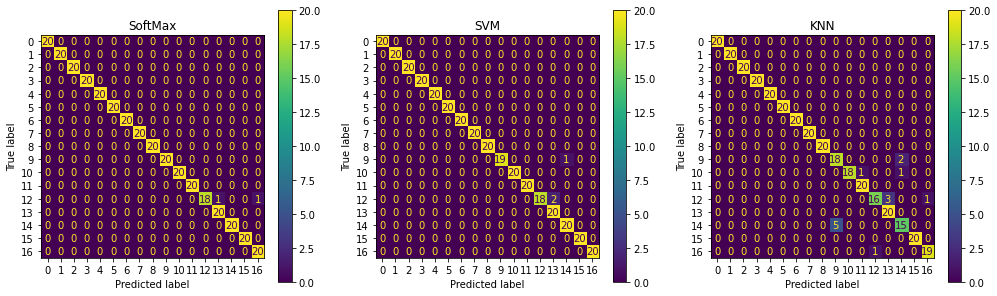

In [9]:
n_iter = 10 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(17,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='accuracy', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=1, 
                                   cv=rkf, random_state=71)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rdmsearch.fit(X1_tr, y_tr)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    print('    Resultados dos parâmetros:')
    for par in rdmsearch.best_params_.keys():
        print('        Parâmetro {}: {}'.format(par, rdmsearch.best_params_[par]))  
    print()
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


### 5.2 - Avaliando paralelização

#### Testando com os mesmos n_iter

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:05:47.102022
    Score treino: 1.0
    Score teste : 0.9941176470588236

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9987083562593393
        Parâmetro SoftMax__C: 118.09536574575979
        Parâmetro SoftMax__l1_ratio: 0.23372659022212572
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:00:12.128513
    Score treino: 0.9901960784313726
    Score teste : 0.9911764705882353

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9578293684939423
        Parâmetro SVM__C: 362.8605519403322
        Parâmetro SVM__degree: 3
        Parâmetro SVM__gamma: 0.0007104995725120601
        Parâmetro SVM__kernel: sigmoid

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:00:06.320948
    Score treino: 1.0
    Score teste : 0.9588235294117647

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 13
        Parâmetro 

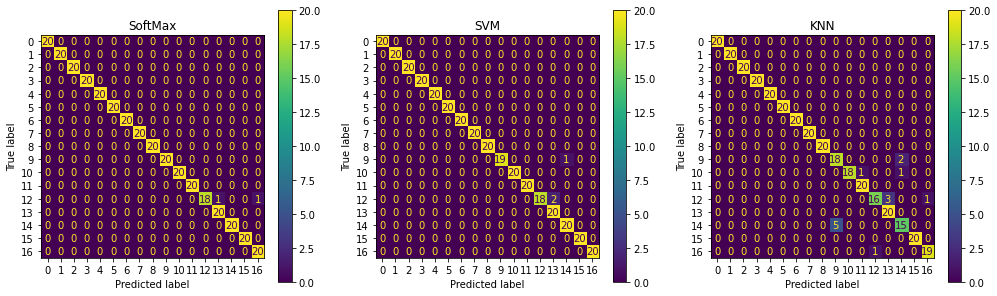

In [10]:
n_iter = 10 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(17,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='accuracy', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=71)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rdmsearch.fit(X1_tr, y_tr)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    print('    Resultados dos parâmetros:')
    for par in rdmsearch.best_params_.keys():
        print('        Parâmetro {}: {}'.format(par, rdmsearch.best_params_[par]))  
    print()
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


#### Aumentando o n_iter

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:50:27.590277
    Score treino: 1.0
    Score teste : 0.9941176470588236

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9987083562593393
        Parâmetro SoftMax__C: 118.09536574575979
        Parâmetro SoftMax__l1_ratio: 0.23372659022212572
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:10.306402
    Score treino: 0.9980392156862745
    Score teste : 1.0

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9996711277039523
        Parâmetro SVM__C: 1.0244925458976766
        Parâmetro SVM__degree: 5
        Parâmetro SVM__gamma: 0.010894813161236078
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:02.317287
    Score treino: 1.0
    Score teste : 0.9911764705882353

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: di

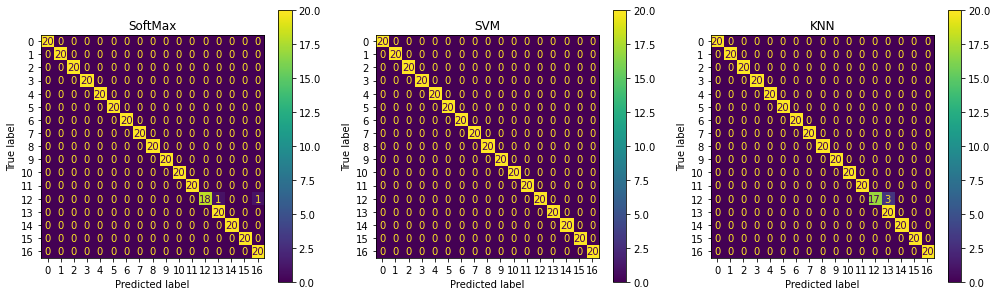

In [11]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(17,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='accuracy', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=71)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rdmsearch.fit(X1_tr, y_tr)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    print('    Resultados dos parâmetros:')
    for par in rdmsearch.best_params_.keys():
        print('        Parâmetro {}: {}'.format(par, rdmsearch.best_params_[par]))  
    print()
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


### 5.3 - Testando os Modelos com o StandardScaler

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 1:09:23.085644
    Score treino: 1.0
    Score teste : 0.9941176470588236

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9987083562593393
        Parâmetro SoftMax__C: 118.09536574575979
        Parâmetro SoftMax__l1_ratio: 0.23372659022212572
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:05.844396
    Score treino: 1.0
    Score teste : 0.9970588235294118

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9996711277039523
        Parâmetro SVM__C: 1.0244925458976766
        Parâmetro SVM__degree: 5
        Parâmetro SVM__gamma: 0.010894813161236078
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:04.248731
    Score treino: 1.0
    Score teste : 0.9852941176470589

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: di

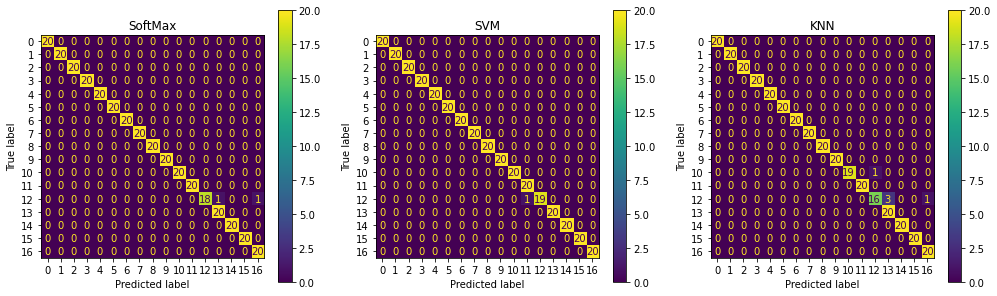

In [12]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(17,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_Standard(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='accuracy', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=71)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rdmsearch.fit(X1_tr, y_tr)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    print('    Resultados dos parâmetros:')
    for par in rdmsearch.best_params_.keys():
        print('        Parâmetro {}: {}'.format(par, rdmsearch.best_params_[par]))  
    print()
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


### 5.4 - Conclusões do Passo 5

* O MinMaxScaler pareceu ser a melhor opção de normalização
* O SVM foi o melhor método considerando o combinado de Score e performance nos dois casos
* Independente da adimensionalização, os parâmetros ótimos foram próximos
* Diferente da conclusão da Atividade03, uma regularização ainda foi consierada positiva pelo RandomizedSearch para o SVM. O kernel e as conclusões de linearidade do problema foram análogas
* De forma geral, os resultados obtidos corroboram as conclusões da Atividade03

## Passo 6 - Comparando os resultados com o default

### 6.1 - Executando métodos default

A execução será feita considerando-se apenas os valores padrão já definidos na declaração dos métodos (vide lista de models).

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:00:00.125177
    Score treino: 0.9921568627450981
    Score teste : 0.9911764705882353

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:00:00.022264
    Score treino: 0.996078431372549
    Score teste : 0.9941176470588236

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:00:00.015623
    Score treino: 0.996078431372549
    Score teste : 0.9852941176470589



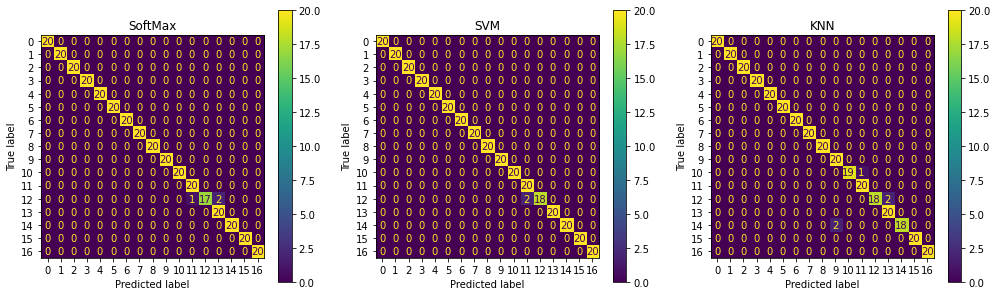

In [13]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(17,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = pipeline
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rdmsearch.fit(X1_tr, y_tr)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


### 6.2 - Conclusões

Pro nosso caso simples, os defaults ficaram bons.

## Passo 7 - Testando com diferentes treino-teste o Pipeline

Vamos tentar repetir o processo de treino-CV e teste para diversas seeds de random_state. Dessa forma, garantiremos a repetibilidade do processo.

### 7.1 - Criando estrutura de dados para armaazenar os resultados

In [14]:
resultados = {}

for model, params in zip(models, parameters):
    
    #print(params)
    model_name = model[0]
    resultados[model_name] = {}
    for param in params.keys():
        resultados[model_name][param] = []
    resultados[model_name]['train_score'] = []
    resultados[model_name]['test_score'] = []
    
print(json.dumps(resultados, indent=4))

{
    "SoftMax": {
        "PCA__n_components": [],
        "SoftMax__l1_ratio": [],
        "SoftMax__C": [],
        "SoftMax__penalty": [],
        "train_score": [],
        "test_score": []
    },
    "SVM": {
        "PCA__n_components": [],
        "SVM__C": [],
        "SVM__kernel": [],
        "SVM__degree": [],
        "SVM__gamma": [],
        "train_score": [],
        "test_score": []
    },
    "KNN": {
        "PCA__n_components": [],
        "KNN__n_neighbors": [],
        "KNN__weights": [],
        "train_score": [],
        "test_score": []
    }
}


### 7.2 - Criando lista de random seeds pro teste (pensando em repetibilidade)

In [15]:
n_tests = 10
rdmseeds = []
add = 0
while len(rdmseeds) < n_tests:
    rdmseeds = np.unique(stats.randint.rvs(1, 99, size=n_tests+add, random_state=71))
    add += 1
for seed in rdmseeds:
    print(seed)

12
19
34
39
41
46
56
81
96
98


### 7.3 - Estruturando o loop

In [18]:
n_iter = 100 #Numero de iterações do rdmsearch 

#Loop principal, iterando sobre as listas
for seed in rdmseeds:
    
    X1_tr, X1_te, y_tr, y_te = train_test_split(X1, y, test_size=size, random_state=seed, stratify=y)
    print('Random seed = {}'.format(seed))
    print()
    
    for model, params in zip(models, parameters):
        
        #print(params)
        model_name = model[0]
        #if model_name == 'SoftMax': continue
        param_arq = resultados[model_name]
        print('Iniciando avaliação do modelo: {}'.format(model_name))
        
        #Primeira etapa - criacao do Pipeline
        pipeline = declara_Pipeline_MinMax(model)
        
        t0 = datetime.now()
        
        #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
        
        rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='accuracy', 
                                       param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                       cv=rkf, random_state=71)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            rdmsearch.fit(X1_tr, y_tr)
            
        print()
        print('    Tempo de execução: {}'.format(datetime.now() - t0))
        print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
        param_arq['train_score'].append(rdmsearch.score(X1_tr, y_tr))
        print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
        param_arq['test_score'].append(rdmsearch.score(X1_te, y_te))
        print()
        print('    Resultados dos parâmetros:')
        for par in rdmsearch.best_params_.keys():
            print('        Parâmetro {}: {}'.format(par, rdmsearch.best_params_[par]))  
            param_arq[par].append(rdmsearch.best_params_[par])
        print()
            


Random seed = 12

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:49:14.817260
    Score treino: 1.0
    Score teste : 0.9970588235294118

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9987083562593393
        Parâmetro SoftMax__C: 118.09536574575979
        Parâmetro SoftMax__l1_ratio: 0.23372659022212572
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:11.357581
    Score treino: 1.0
    Score teste : 0.9970588235294118

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9946879092846495
        Parâmetro SVM__C: 4.925575727269707
        Parâmetro SVM__degree: 3
        Parâmetro SVM__gamma: 0.00035311053059889453
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:02.385107
    Score treino: 1.0
    Score teste : 0.9882352941176471

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmet


    Tempo de execução: 0:01:01.887415
    Score treino: 1.0
    Score teste : 0.9764705882352941

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: distance
        Parâmetro PCA__n_components: 0.9993068046091984

Random seed = 96

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:51:31.186202
    Score treino: 1.0
    Score teste : 1.0

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9987083562593393
        Parâmetro SoftMax__C: 118.09536574575979
        Parâmetro SoftMax__l1_ratio: 0.23372659022212572
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:09.889463
    Score treino: 1.0
    Score teste : 1.0

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9946879092846495
        Parâmetro SVM__C: 4.925575727269707
        Parâmetro SVM__degree: 3
        Parâmetro SVM__gamma: 0.00035311053059889453
        Parâmetro SVM

### 7.4 - Resultados SoftMax

In [19]:
pd.DataFrame(resultados['SoftMax'])

,PCA__n_components,SoftMax__l1_ratio,SoftMax__C,SoftMax__penalty,train_score,test_score
0,0.998708,0.233727,118.095366,none,1.0,0.997059
1,0.967669,0.940556,2.561866,none,1.0,1.000000
2,0.998708,0.233727,118.095366,none,1.0,0.997059
3,0.998708,0.233727,118.095366,none,1.0,0.997059
4,0.998708,0.233727,118.095366,none,1.0,0.997059
5,0.998708,0.233727,118.095366,none,1.0,1.000000
6,0.998708,0.233727,118.095366,none,1.0,0.997059
7,0.998708,0.233727,118.095366,none,1.0,0.997059
8,0.998708,0.233727,118.095366,none,1.0,1.000000
9,0.998708,0.233727,118.095366,none,1.0,0.997059


### 7.5 - Resultados SVM

In [20]:
pd.DataFrame(resultados['SVM'])

,PCA__n_components,SVM__C,SVM__kernel,SVM__degree,SVM__gamma,train_score,test_score
0,0.994688,4.925576,linear,3,0.000353,1.000000,0.997059
1,0.977443,968.581327,rbf,3,0.012123,1.000000,1.000000
2,0.994688,4.925576,linear,3,0.000353,1.000000,0.997059
3,0.977443,968.581327,rbf,3,0.012123,1.000000,1.000000
4,0.999671,1.024493,linear,5,0.010895,0.998039,0.997059
5,0.999671,1.024493,linear,5,0.010895,1.000000,0.997059
6,0.999671,1.024493,linear,5,0.010895,1.000000,0.991176
7,0.994688,4.925576,linear,3,0.000353,1.000000,1.000000
8,0.994688,4.925576,linear,3,0.000353,1.000000,0.997059
9,0.994688,4.925576,linear,3,0.000353,1.000000,0.997059


### 7.6 - Resultados KNN

In [21]:
pd.DataFrame(resultados['KNN'])

,PCA__n_components,KNN__n_neighbors,KNN__weights,train_score,test_score
0,0.999307,10,distance,1.0,0.988235
1,0.999307,10,distance,1.0,0.988235
2,0.999307,10,distance,1.0,0.988235
3,0.999307,10,distance,1.0,0.988235
4,0.999307,10,distance,1.0,0.991176
5,0.999307,10,distance,1.0,0.985294
6,0.999307,10,distance,1.0,0.985294
7,0.999307,10,distance,1.0,0.988235
8,0.999307,10,distance,1.0,0.988235
9,0.999307,10,distance,1.0,0.976471


### 7.7 - Conclusões da etapa 7

* O pipeline proposto ajustou bem para todos os conjuntos de treino e teste
* Poucos casos desviaram do esperado, mas mesmo os desvios (ex.: kernel rbf em alguns SVMs) estão de acordo com conclusões da Atividade03